In [21]:
from collections import defaultdict
from itertools import product
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from algorithms.svr import SupportVectorRegressor
from algorithms.preprocessing import load_and_preprocess_dataset
from algorithms.model_selection import DEFAULT_METRICS
import config

In [22]:
X_train, y_train, X_test, y_test = load_and_preprocess_dataset()

In [23]:
ridge_logs_dir = config.LOGS_DIR / 'ridge'
nn_logs_dir = config.LOGS_DIR / 'nn'
svr_logs_dir = config.LOGS_DIR / 'svr'

In [24]:
hyperparameters = [
    (0.1, 0.001, 0.01, 'linear', 0.5),
    (0.1, 0.001, 0.01, 'rbf', 0.5),
    (0.1, 0.001, 0.001, 'linear', 0.5),
    (0.1, 0.001, 0.001, 'rbf', 0.5),
    (0.1, 0.001, 0.001, 'rbf', 1),
    (0.1, 0.01, 0.01, 'linear', 0.5),
    (0.1, 0.01, 0.001, 'rbf', 0.5),
    (0.2, 0.001, 0.001, 'rbf', 0.5),
    (0.2, 0.001, 0.001, 'rbf', 1),
    (0.2, 0.01, 0.001, 'linear', 1),
    (0.2, 0.01, 0.001, 'rbf', 1),
]

In [25]:
svr_scores = []
for C, epsilon, tolerance, kernel_type, gamma in hyperparameters:
    with open(svr_logs_dir / f'C_{C}-epsilon_{epsilon}-tolerance_{tolerance}-kernel_type_{kernel_type}-gamma_{gamma}.pkl', 'rb') as f:
        ridge_histories = pickle.load(f)
    svr_scores.append(ridge_histories)

In [34]:
svr_last_scores = []

for model in svr_scores:
    model_last_scores = defaultdict(int)
    for fold in model:
        for metric in DEFAULT_METRICS.keys():
            model_last_scores[f'train_{metric}'] += fold[f'train_{metric}'][-1] / len(model)
            model_last_scores[f'valid_{metric}'] += fold[f'valid_{metric}'][-1] / len(model)
    svr_last_scores.append(model_last_scores)

In [35]:
valid_svr = {metric: [ls[f'valid_{metric}'] for ls in svr_last_scores] for metric in DEFAULT_METRICS.keys()}

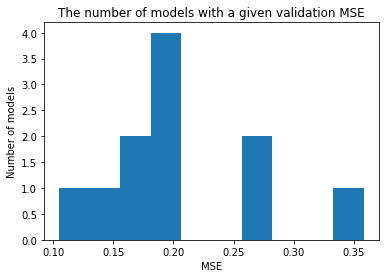

In [36]:
plt.figure()
plt.title('The number of models with a given validation MSE')
plt.xlabel('MSE')
plt.ylabel('Number of models')
plt.hist(valid_svr['MSE'])
plt.show()

In [38]:
print(np.mean(valid_svr['MSE']))

0.20422637781016342


In [39]:
svr_best_score = np.inf
svr_best_model_index = -1

for i, model in enumerate(svr_last_scores):
    if model['valid_MAPE'] < svr_best_score:
        ridge_best_model_index = i
        ridge_best_score = model['valid_MAPE']

In [41]:
for k, v in svr_last_scores[ridge_best_model_index].items():
    if k.startswith('train'):
        print(k, v)

train_MSE 0.22059964842270924
train_MAE 0.14952688085838775
train_MAPE 0.3899905503157619
train_R2 0.8220526415872558


In [43]:
for k, v in svr_last_scores[ridge_best_model_index].items():
    if k.startswith('valid'):
        print(k, v)

valid_MSE 0.26656900347798834
valid_MAE 0.18925390824181415
valid_MAPE 0.5614878388728056
valid_R2 0.7821953053473298


In [46]:
print(np.mean(valid_svr['MSE']), np.std(valid_svr['MSE']))

0.20422637781016342 0.0661987186617074
